# Image binarization - model training

Copyright 2020 Sami Liedes

Based on the TensorFlow image segmentation tutorial, Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

import math
import os

from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

In [4]:
BASE_DIR = os.path.join(os.getcwd(), '..')
DATA_DIR = os.path.join(BASE_DIR, 'rotated')

if not os.path.exists(os.path.join(DATA_DIR, 'train', 'orig')):
    raise RuntimeError('Please run the notebook from the directory where you have ../train/. ' +
                      ('Searched from: ' + os.path.join(DATA_DIR, 'train', 'orig')))

train_list_ds = tf.data.Dataset.list_files(DATA_DIR + '/train/orig/*', shuffle=True)
test_list_ds = tf.data.Dataset.list_files(DATA_DIR + '/test/orig/*', shuffle=False)

In [5]:
DIM = 224
CLASSIFICATION_RANDOM = True  # nondeterministically binarize gray pixels

CONTRAST_BLUR = True
NUM_RND_SIN = 10

In [6]:
for f in train_list_ds.take(5):
    print(f.numpy())

b'/home/sliedes/projects/binarize/seg/../rotated/train/orig/phibd12_Persian06_4.png'
b'/home/sliedes/projects/binarize/seg/../rotated/train/orig/dibco13_PR04_18.png'
b'/home/sliedes/projects/binarize/seg/../rotated/train/orig/phibd12_Persian04_scale0.5_0.png'
b'/home/sliedes/projects/binarize/seg/../rotated/train/orig/1Ampumat_1_130.png'
b'/home/sliedes/projects/binarize/seg/../rotated/train/orig/GustafMa_12_partial_56.png'


In [7]:
def rnd_blob():
    sin_freq_x = tf.random.normal([NUM_RND_SIN], stddev=5.0)
    sin_freq_y = tf.random.normal([NUM_RND_SIN], stddev=5.0)
    sin_off_x = tf.random.uniform([NUM_RND_SIN], 0, 2*math.pi)
    sin_off_y = tf.random.uniform([NUM_RND_SIN], 0, 2*math.pi)
    im = tf.zeros([DIM, DIM])
    coords = tf.linspace(0.0, 1.0, DIM)
    sines = tf.math.sin((coords[:, None, None] + sin_off_y) * sin_freq_y + (coords[None, :, None] + sin_off_x) * sin_freq_x)
    sine_sum = tf.math.reduce_sum(sines, axis=2)
    sine_sum -= tf.math.reduce_min(sine_sum)
    sine_sum /= tf.math.reduce_max(sine_sum)
    sine_sum = tf.clip_by_value(sine_sum, -0.5, 0.5) / 0.5
    return sine_sum

In [8]:
def contrast_blur(img, return_rnd=False):
    tgt_color_coords = tf.cast(tf.random.uniform([2], -0.5, DIM - 0.5), tf.int32)
    tgt_color = img[tgt_color_coords[0], tgt_color_coords[1]]
    rnd = tf.expand_dims(rnd_blob(), -1)
    rnd -= tf.math.reduce_min(rnd)
    rnd /= tf.math.reduce_max(rnd)
    img = rnd * (img - tgt_color) + tgt_color
    if return_rnd:
        return img, rnd
    else:
        return img

In [9]:
def process_path(orig_path, augment=True):
    img = tf.cast(tf.image.decode_png(tf.io.read_file(orig_path), channels=3), tf.float32)
    img.set_shape([DIM, DIM, 3])
    mask = tf.image.decode_png(tf.io.read_file(tf.strings.regex_replace(orig_path, '/orig/', '/mask/')), channels=1)
    mask.set_shape([DIM, DIM, 1])
    if CLASSIFICATION_RANDOM and augment:
        rnd = tf.cast(tf.random.uniform(mask.shape) * 256.0, tf.uint8)
        mask = (mask >= rnd)
    else:
        mask = (mask >= 128)
    mask = tf.cast(mask, tf.int32)

    if augment:
        img = tf.image.random_hue(img, 0.5)

        do_flip = tf.random.uniform(orig_path.shape) > 0.5
        img = tf.cond(do_flip, lambda: tf.image.flip_left_right(img), lambda: img)
        mask = tf.cond(do_flip, lambda: tf.image.flip_left_right(mask), lambda: mask)

        do_flip = tf.random.uniform(orig_path.shape) > 0.5
        img = tf.cond(do_flip, lambda: tf.image.flip_up_down(img), lambda: img)
        mask = tf.cond(do_flip, lambda: tf.image.flip_up_down(mask), lambda: mask)
    
    if augment and CONTRAST_BLUR:
        with tf.device("/gpu:0"):
            img = contrast_blur(img)
    
    return img, mask

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_list_ds.map(lambda x: process_path(x, augment=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
print('Test size:', len(test_ds))
print('Train size:', len(train_ds))

Test size: 143
Train size: 6565


In [12]:
TRAIN_LENGTH = len(train_ds)
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [13]:
train_dataset = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_ds.batch(BATCH_SIZE)

In [14]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  # title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    # plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

## Contrast blur example

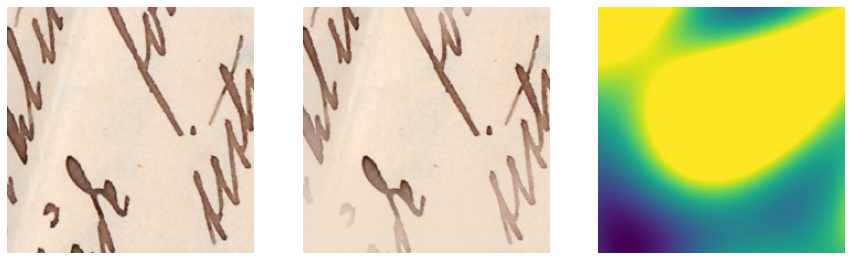

In [15]:
for image, mask in test_ds:
    sample_image, sample_mask = image, mask
    # print(tf.math.reduce_min(sample_mask), tf.math.reduce_max(sample_mask))
    if DIM * DIM - tf.math.reduce_sum(mask) > 8000:
        break
# diff = sample_image - contrast_blur(sample_image)
blurred, blur_rnd = contrast_blur(sample_image, return_rnd=True)
display([sample_image, blurred, blur_rnd])

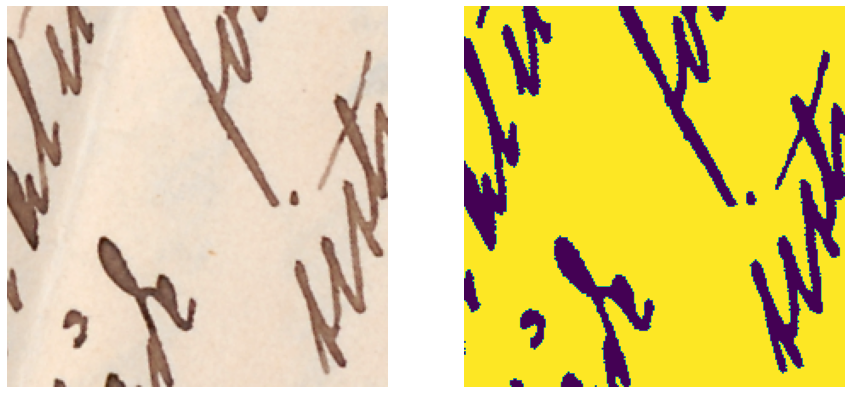

In [16]:
for image, mask in test_ds:
    sample_image, sample_mask = image, mask
    # print(tf.math.reduce_min(sample_mask), tf.math.reduce_max(sample_mask))
    # print(DIM*DIM - tf.math.reduce_sum(mask))
    if DIM*DIM - tf.math.reduce_sum(mask) > 8000:
        break
display([sample_image, sample_mask])

## Model definition
The model being used here is a modified U-Net, with a pretrained MobileNetV2 model as encoder.

In [17]:
OUTPUT_CHANNELS = 1

In [18]:
# Note: layers=tf.keras.layers needed to make batchnorm finetuning work sensibly
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False,
                                               layers=tf.keras.layers)


layer_names = [
    'block_1_expand_relu',   # 112x112
    'block_3_expand_relu',   # 56x56
    'block_6_expand_relu',   # 28x28
    'block_13_expand_relu',  # 14x14
    'block_16_project',      # 7x7x320
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

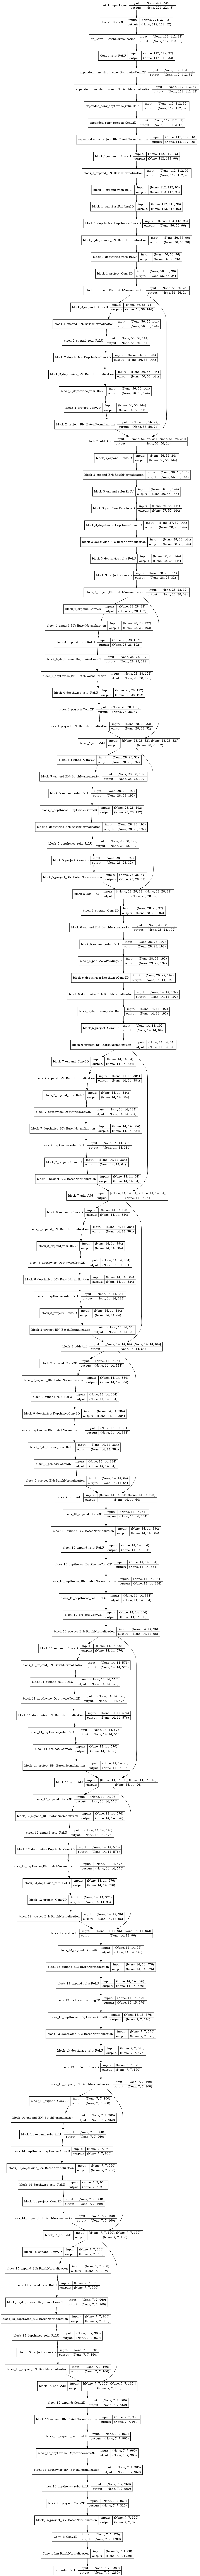

In [19]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [20]:
MULT = 2

up_stack = [
#    pix2pix.upsample(512, 3, apply_dropout=True),  # 7x7 -> 14x14
#    pix2pix.upsample(256, 3, apply_dropout=True),  # 8x8 -> 16x16
#    pix2pix.upsample(128, 3, apply_dropout=True),  # 16x16 -> 32x32
#    pix2pix.upsample(64, 3, apply_dropout=True),   # 32x32 -> 64x64
    pix2pix.upsample(256 * MULT, 3, apply_dropout=True),  # 7x7 -> 14x14
    pix2pix.upsample(128 * MULT, 3, apply_dropout=True),  # 8x8 -> 16x16
    pix2pix.upsample(64 * MULT, 3, apply_dropout=True),  # 16x16 -> 32x32
    pix2pix.upsample(32 * MULT, 3, apply_dropout=True),   # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  
    x = inputs

    # x = tf.keras.layers.GaussianNoise(10.0)(inputs)
    # x = tf.keras.layers.GaussianDropout(dropout_prob)(inputs)
    # x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        # x = tf.keras.layers.Dropout(0.5)(x)

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

In [22]:
model = unet_model(OUTPUT_CHANNELS)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # 'adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

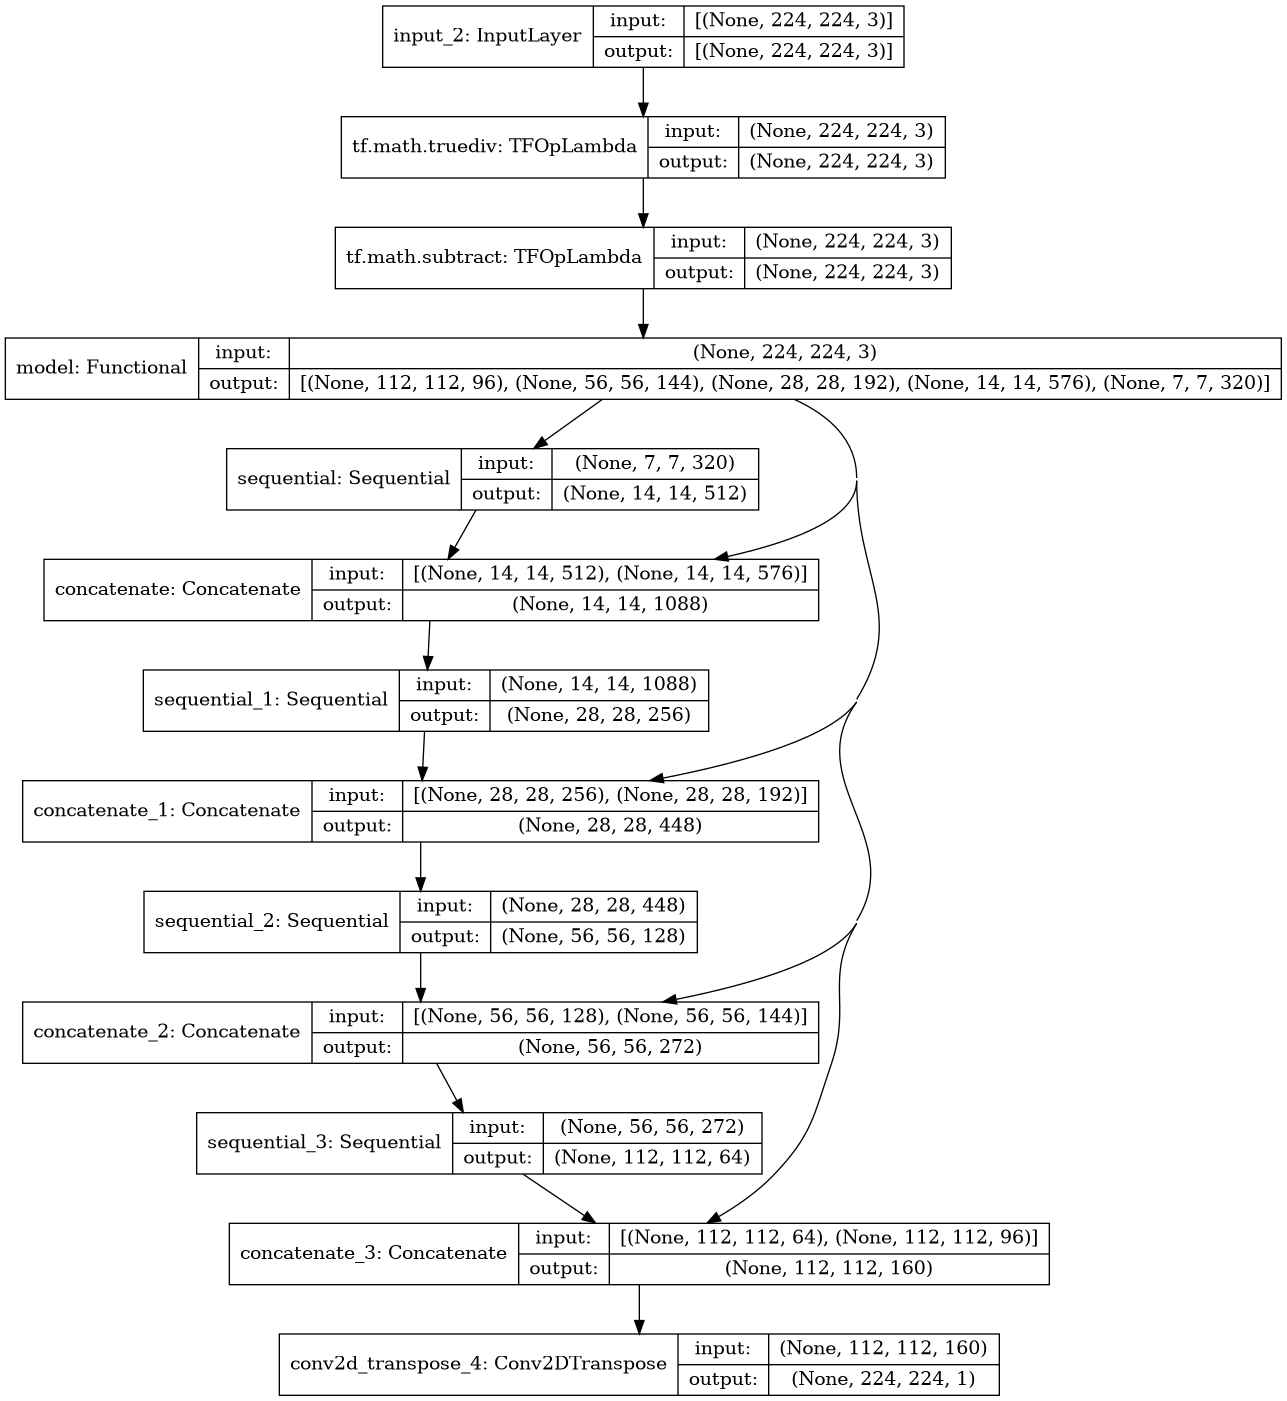

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
def create_mask(pred_mask):
  return pred_mask[0]

In [25]:
def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

## What the model predicts before training

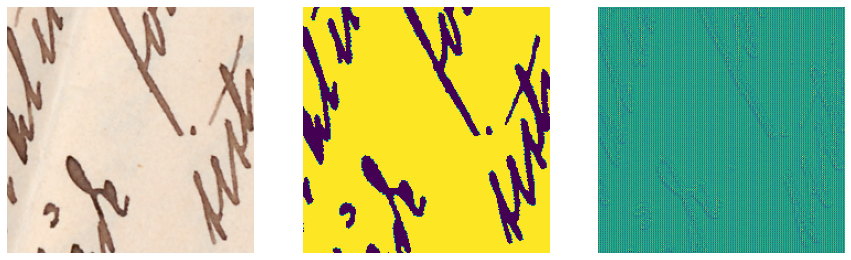

In [26]:
show_predictions(model)

In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [28]:
EPOCHS = 2000
VAL_SUBSPLITS = 1
VALIDATION_STEPS = int(math.ceil(len(test_ds)/BATCH_SIZE/VAL_SUBSPLITS))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/2000
205/205 [==============================] - 64s 202ms/step - loss: 0.1926 - accuracy: 0.9169 - val_loss: 0.0590 - val_accuracy: 0.9806
Epoch 2/2000
205/205 [==============================] - 45s 120ms/step - loss: 0.0507 - accuracy: 0.9808 - val_loss: 0.0490 - val_accuracy: 0.9839
Epoch 3/2000
205/205 [==============================] - 25s 123ms/step - loss: 0.0447 - accuracy: 0.9827 - val_loss: 0.0456 - val_accuracy: 0.9850
Epoch 4/2000
205/205 [==============================] - 25s 122ms/step - loss: 0.0425 - accuracy: 0.9836 - val_loss: 0.0414 - val_accuracy: 0.9864
Epoch 5/2000
205/205 [==============================] - 25s 122ms/step - loss: 0.0418 - accuracy: 0.9834 - val_loss: 0.0310 - val_accuracy: 0.9885
Epoch 6/2000
205/205 [==============================] - 25s 120ms/step - loss: 0.0395 - accuracy: 0.9843 - val_loss: 0.0310 - val_accuracy: 0.9886
Epoch 7/2000
205/205 [==============================] - 25s 120ms/step - loss: 0.0379 - accuracy: 0.9848 - val_loss: 0

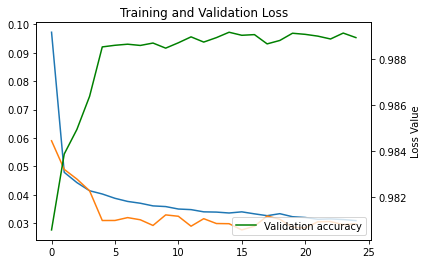

In [29]:
epochs = range(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'], label='Training loss')
ax.plot(epochs, model_history.history['val_loss'], label='Validation loss')
ax2 = ax.twinx()
ax2.plot(epochs, np.array(model_history.history['val_accuracy']), 'g', label='Validation accuracy')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [30]:
def rot(a, n):
    if n == 0:
        return a
    elif n == 1:
        return tf.image.flip_left_right(a)
    elif n == 2:
        return tf.image.flip_up_down(a)
    elif n == 3:
        return tf.image.rot90(a, k=1)
    elif n == 4:
        return tf.image.rot90(a, k=2)
    elif n == 5:
        return tf.image.rot90(a, k=3)
    elif n == 6:
        return tf.image.rot90(tf.image.flip_left_right(a), k=1)
    elif n == 7:
        return tf.image.rot90(tf.image.flip_left_right(a), k=3)
    assert False, n
    
def reverse_rot(a, n):
    if n in [0, 1, 2, 4, 6, 7]:
        return rot(a, n)
    if n == 3:
        return rot(a, 5)
    if n == 5:
        return rot(a, 3)
    assert False, n

In [31]:
def rot_model():
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])
    preds = [reverse_rot(model(rot(inputs, n)), n) for n in range(8)]
    result = tf.math.reduce_mean(tf.convert_to_tensor(preds), axis=0)
    return tf.keras.Model(inputs=inputs, outputs=result)

In [32]:
rmodel = rot_model()
rmodel.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

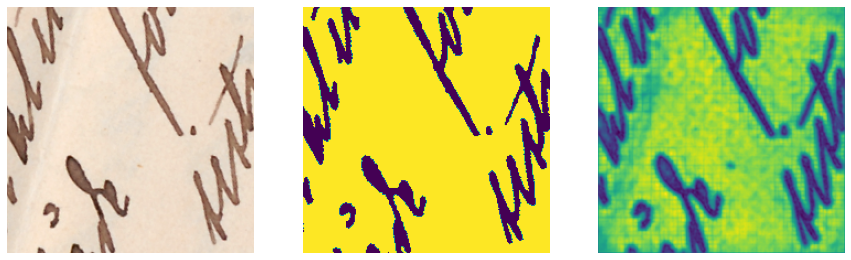

In [33]:
show_predictions(rmodel)

In [34]:
rmodel.evaluate(test_dataset)

5/5 [==============================] - 9s 327ms/step - loss: 0.0961 - accuracy: 0.9909


[0.10118690878152847, 0.9900211691856384]

## Predictions on the test dataset

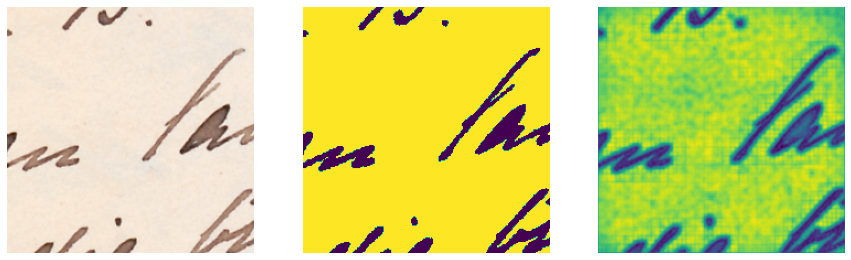

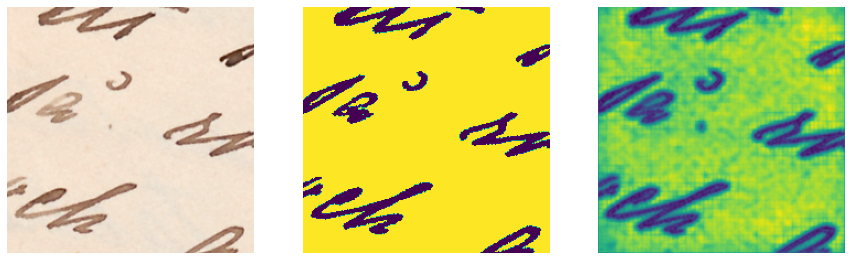

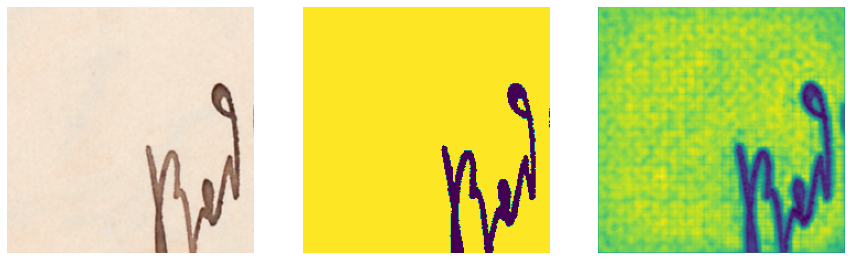

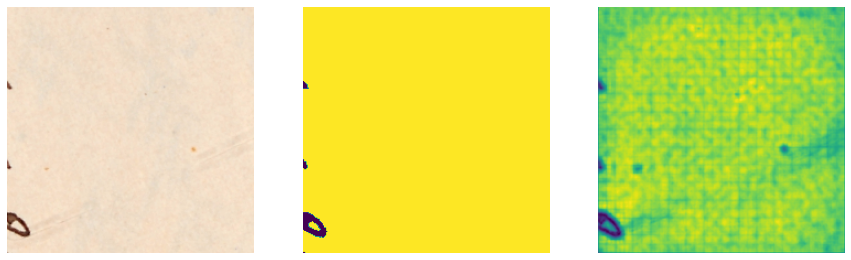

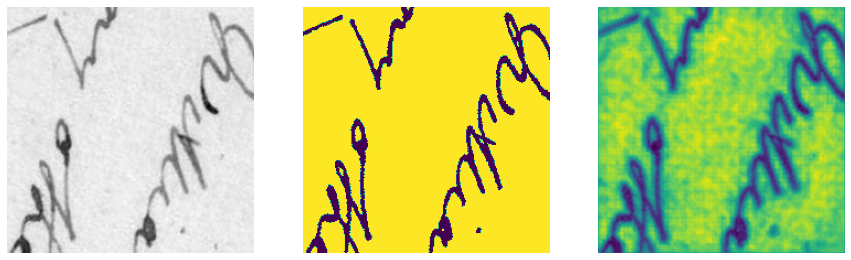

In [35]:
show_predictions(rmodel, test_dataset, 20)

In [36]:
rmodel.save(os.path.join(BASE_DIR, 'model'))

INFO:tensorflow:Assets written to: /home/sliedes/projects/binarize/seg/../model/assets


In [37]:
test_preds = rmodel.predict(test_dataset)

In [38]:
test_preds.shape

(143, 224, 224, 1)

In [39]:
test_gt_dataset = test_ds.map(lambda x, y: y)
test_gt = next(iter(test_gt_dataset.batch(len(test_gt_dataset)))).numpy()

In [40]:
test_gt.shape

(143, 224, 224, 1)

In [41]:
test_preds = test_preds.flatten()
test_gt = test_gt.flatten()
pred_sort = tf.argsort(test_preds)
test_gt = test_gt[pred_sort]
test_preds = test_preds[pred_sort]
test_preds = tf.math.sigmoid(test_preds)

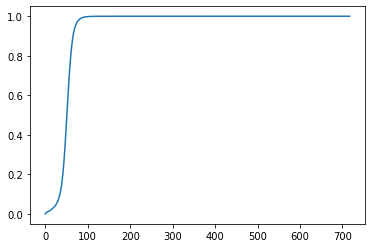

In [42]:
plt.plot(test_preds[::10000]);

## Do isotonic regression to calibrate the output to represent probability

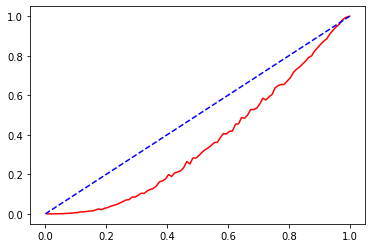

In [43]:
prob_true, prob_pred = calibration_curve(test_gt, test_preds, n_bins=100)

plt.plot(prob_pred, prob_true, 'r')
plt.plot([0, 1], [0, 1], 'b--')

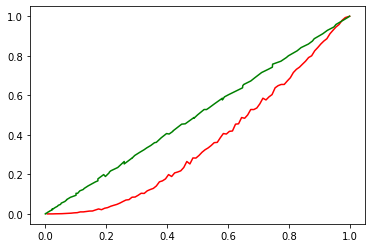

In [44]:
iso = IsotonicRegression()
iso.fit(test_preds, test_gt)

plt.plot(prob_pred, prob_true, 'r')
plt.plot(iso.predict(prob_pred), prob_true, 'g')

np.savez(os.path.join(BASE_DIR, 'model/isoregr.npz'),
        X=iso.X_thresholds_, y=iso.y_thresholds_)